In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


CAPTURING THE IMAGES (using the dlib face detector to convert video to face images)

In [ ]:
import dlib 
import cv2
import os
import json 

In [ ]:
train_frame_path = '/content/drive/MyDrive/DeepfakeProject/train_videos/'

with open(os.path.join(train_frame_path, 'metadata.json'), 'r') as file: 
    data = json.load(file)

train_data_list = [f for f in os.listdir(train_frame_path) if f.endswith('.mp4')] 
detector = dlib.get_frontal_face_detector() #loading the detector
for vid in train_data_list:
    count = 0
    capture = cv2.VideoCapture(os.path.join(train_frame_path, vid)) 
    frame_rate = capture.get(5) #CAP_PROP_FPS - frame rate.
    while capture.isOpened(): 
        frame_ID = capture.get(1) # CAP_PROP_POS_FRAMES - 0-based index of the frame to be decoded/captured next
        ret, frame = capture.read() # Capture frame-by-frame
        if ret != True:
          break
        if frame_ID % ((int(frame_rate)+1)*1) == 0:
            face_rects, scores, idx = detector.run(frame, 0) 
                                                             
            for i, d in enumerate(face_rects): #enumarating the left,top,right and bottom edges of all face rectangles
                x1 = d.left()
                y1 = d.top()
                x2 = d.right()
                y2 = d.bottom()
                crop_image = frame[y1:y2, x1:x2] #croping the images based on the rectangles 
                if data[vid]['label'] == 'REAL':
                    try:
                      cv2.imwrite('/content/drive/MyDrive/DeepfakeProject/dataset/real/'+vid.split('.')[0]+'_'+str(count)+'.png', cv2.resize(crop_image, (128, 128)))# Saving the image
                    except:
                        break
                elif data[vid]['label'] == 'FAKE':
                  try:
                    cv2.imwrite('/content/drive/MyDrive/DeepfakeProject/dataset/fake/'+vid.split('.')[0]+'_'+str(count)+'.png', cv2.resize(crop_image, (128, 128)))# Saving the image
                  except:
                    break
                count+=1

TRAINING THE DEEPFAKE DETECTION (training the dataset with captured images and outputing the model file)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
input_shape = (128,128,3)
data_directory = '/content/drive/MyDrive/DeepfakeProject/dataset'

real_data = [f for f in os.listdir(data_directory+'/real') if f.endswith('.png')] #defining the data
fake_data = [f for f in os.listdir(data_directory+'/fake') if f.endswith('.png')]

X=[]
Y=[]

for image in real_data:
  X.append(img_to_array(load_img(data_directory+'/real/'+image)).flatten()/255.0) #return a copy of the array collapsed into one dimension then divide it by 255 to bring the pixel values between 0 and 1
  Y.append(1)
for image in fake_data:
  X.append(img_to_array(load_img(data_directory+'/fake/'+image)).flatten()/255.0)
  Y.append(0)
  
Y_original = Y

#Normalizing the data 
X = np.array(X)
Y = to_categorical(Y,2) #returns a matrix of binary values with the number of rows equal to the length of the input vector and the number of columns equal to the number of classes

#Reshaping 
X=X.reshape(-1,128,128,3)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.4, random_state=5)

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
googleNet_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
googleNet_model.trainable = True

model = Sequential() #creating a sequential model 
model.add(googleNet_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.6)) 
model.add(Dense(units=2, activation='softmax')) #softmax converts a real vector to a vector of categorical probabilities; the elements of the output vector are in range (0, 1) and sum to 1

#configuring the model with losses and metrics
model.compile(loss='binary_crossentropy', #computes the cross-entropy loss between true labels and predicted labels
              optimizer=optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])

model.summary()

219062272/219055592 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 2, 2, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3074      
Total params: 54,339,810
Trainable params: 54,279,266
Non-trainable params: 60,544
_________________________________________________________________


In [ ]:
epochs = 10
batch_size = 100
history = model.fit(X_train, Y_train, batch_size, epochs, validation_data = (X_test, Y_test), verbose = 1, shuffle=True)

Epoch 1/10
1/1 [==============================] - 50s 50s/step - loss: 0.8549 - accuracy: 0.4000 - val_loss: 0.9368 - val_accuracy: 0.6719
Epoch 2/10
1/1 [==============================] - 29s 29s/step - loss: 0.6432 - accuracy: 0.6211 - val_loss: 0.8824 - val_accuracy: 0.7812
Epoch 3/10
1/1 [==============================] - 29s 29s/step - loss: 0.4514 - accuracy: 0.9053 - val_loss: 0.8363 - val_accuracy: 0.7500
Epoch 4/10
1/1 [==============================] - 29s 29s/step - loss: 0.3932 - accuracy: 0.9579 - val_loss: 0.7765 - val_accuracy: 0.7812
Epoch 5/10
1/1 [==============================] - 29s 29s/step - loss: 0.2856 - accuracy: 0.9895 - val_loss: 0.7330 - val_accuracy: 0.7969
Epoch 6/10
1/1 [==============================] - 29s 29s/step - loss: 0.2465 - accuracy: 0.9789 - val_loss: 0.6944 - val_accuracy: 0.8281
Epoch 7/10
1/1 [==============================] - 30s 30s/step - loss: 0.1645 - accuracy: 0.9895 - val_loss: 0.6616 - val_accuracy: 0.8125
Epoch 8/10
1/1 [===========

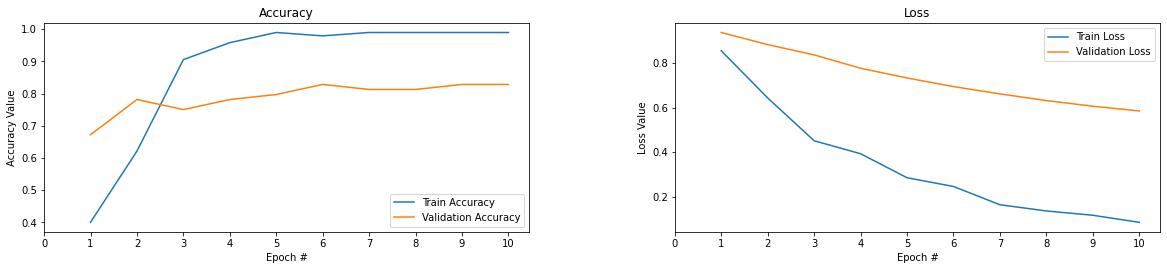

In [ ]:
 #plotting the accuracy and loss

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


True positive =  93
False positive =  16
False negative =  8
True negative =  42




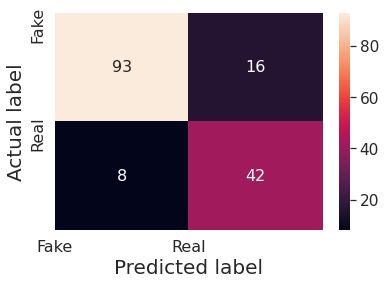

In [ ]:
#Output confusion matrix

def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    
print_confusion_matrix(Y_original, model.predict_classes(X))

In [ ]:
model.save('deepfake-detection-model.h5')

DEEPFAKE DETECTION (loading the model and inputting a video to detect whether it is fake or not)

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
tf.__version__


'2.4.1'

In [ ]:
model = load_model('deepfake-detection-model.h5')


In [ ]:
test_frame_path = '/content/drive/MyDrive/DeepfakeProject/test_videos'

test_data_list = [f for f in os.listdir(test_frame_path) if f.endswith('.mp4')] 
detector = dlib.get_frontal_face_detector() #loading the detector
for vid in test_data_list:
    count = 0
    capture = cv2.VideoCapture(os.path.join(test_frame_path, vid)) 
    frame_rate = capture.get(5) #CAP_PROP_FPS - frame rate.
    while capture.isOpened():
        frame_ID = capture.get(1) # CAP_PROP_POS_FRAMES - 0-based index of the frame to be decoded/captured next
        ret, frame = capture.read() # Capture frame-by-frame
        if ret != True:
          break
        if frame_ID % ((int(frame_rate)+1)*1) == 0:
            face_rects, scores, idx = detector.run(frame, 0)  
                                                             
            for i, d in enumerate(face_rects): #enumarating the left,top,right and bottom edges of all face rectangles
                x1 = d.left()
                y1 = d.top()
                x2 = d.right()
                y2 = d.bottom()
                crop_image = frame[y1:y2, x1:x2] #croping the images based on the rectangles 
                cv2.imwrite('/content/drive/MyDrive/DeepfakeProject/dataset/test/'+vid.split('.')[0]+'_'+str(count)+'.png', cv2.resize(crop_image, (128, 128)))# Saving the image
                data = img_to_array(cv2.resize(crop_image, (128, 128))).flatten() / 255.0
                data = data.reshape(-1, 128, 128, 3)
                print(model.predict_classes(data)) #most likely class (highest probability value)
                count+=1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[0]
[0]
[1]
[0]
